In [2]:
# importing necessary libraries
import os
import warnings
import numpy as np    # linear algebra
import pandas as pd   # data processing
import seaborn as sns # visualization
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score    
from sklearn.model_selection import StratifiedKFold, KFold   

%matplotlib inline
print(os.listdir("../input"))
warnings.filterwarnings('ignore')

['dont-call-me-turkey']


**Loading data...**

In [3]:
train  = pd.read_json('../input/dont-call-me-turkey/train.json')
test   = pd.read_json('../input/dont-call-me-turkey/test.json')
sample = pd.read_csv('../input/dont-call-me-turkey/sample_submission.csv')

In [4]:
train.shape, test.shape

((1195, 5), (1196, 4))

In [5]:
train.head()

,audio_embedding,is_turkey,vid_id,end_time_seconds_youtube_clip,start_time_seconds_youtube_clip
0,"[[172, 34, 216, 110, 208, 46, 95, 66, 161, 125...",0,kDCk3hLIVXo,70,60
1,"[[169, 20, 165, 102, 205, 62, 110, 103, 211, 1...",1,DPcGzqHoo7Y,40,30
2,"[[148, 8, 138, 60, 237, 48, 121, 108, 145, 177...",1,7yM63MTHh5k,240,230
3,"[[151, 0, 162, 88, 171, 71, 47, 90, 179, 190, ...",1,luG3RmUAxxM,520,510
4,"[[162, 17, 187, 111, 211, 105, 92, 67, 203, 15...",0,PIm3cjxTpOk,10,0


In [6]:
train.info()
print('\n','*'* 57,'\n')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195 entries, 0 to 1194
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   audio_embedding                  1195 non-null   object
 1   is_turkey                        1195 non-null   int64 
 2   vid_id                           1195 non-null   object
 3   end_time_seconds_youtube_clip    1195 non-null   int64 
 4   start_time_seconds_youtube_clip  1195 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 46.8+ KB

 ********************************************************* 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196 entries, 0 to 1195
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   audio_embedding                  1196 non-null   object
 1   vid_id                           1196 non-null   object
 2  

**Checking if there are any common ids in train & test sets**

In [7]:
train_ids = set(train['vid_id'])
test_ids = set(test['vid_id'])
common_id = train_ids.intersection(test_ids)
common_id

set()

**Exploratory Data Analysis**

Text(0.5, 1.0, 'Distribution of is_turkey')

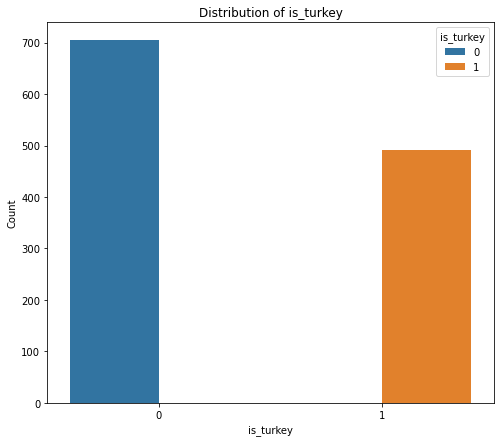

In [8]:
plt.figure(figsize=(8,7))
sns.countplot(x='is_turkey', hue='is_turkey', data=train)
plt.xlabel('is_turkey')
plt.ylabel('Count')
plt.title('Distribution of is_turkey')

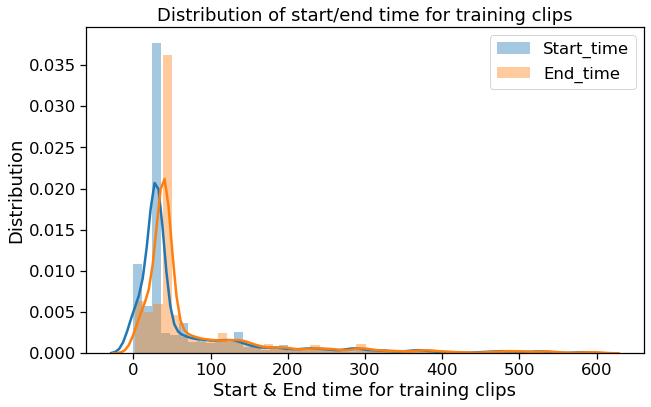

In [9]:
plt.figure(figsize=(10,6))
sns.despine()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.distplot(train['start_time_seconds_youtube_clip'], label='Start_time')
sns.distplot(train['end_time_seconds_youtube_clip'], label='End_time')
plt.title('Distribution of start/end time for training clips')
plt.xlabel('Start & End time for training clips')
plt.ylabel('Distribution')
plt.legend()

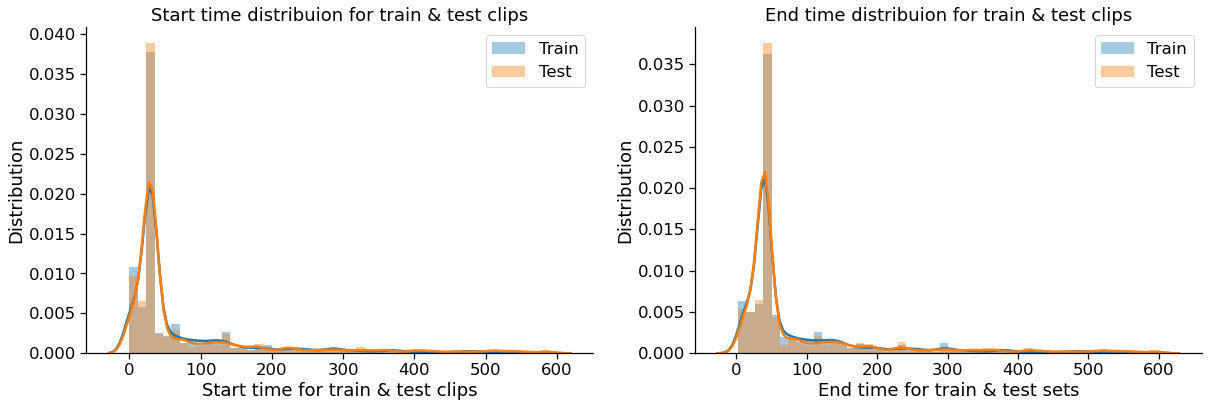

In [10]:
fig, axes = plt.subplots(figsize = (20,6))

plt.subplot(1,2,1)
sns.despine()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.distplot(train['start_time_seconds_youtube_clip'], label='Train')
sns.distplot(test['start_time_seconds_youtube_clip'], label='Test')
plt.title('Start time distribuion for train & test clips')
plt.xlabel('Start time for train & test clips')
plt.ylabel('Distribution')
plt.legend()

plt.subplot(1,2,2)
sns.despine()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.distplot(train['end_time_seconds_youtube_clip'], label='Train')
sns.distplot(test['end_time_seconds_youtube_clip'], label='Test')
plt.title('End time distribuion for train & test clips')
plt.xlabel('End time for train & test sets')
plt.ylabel('Distribution')
plt.legend()

Distributon is positively skewed 

In [12]:
# Function to create dataframe from 2D array
def create_df(data, i):
    df = pd.DataFrame([x for x in data['audio_embedding'].iloc[i]])
    df['vid_id'] = data['vid_id'].iloc[i]
    return df

In [14]:
vid_train = []    # container to hold train set dataframes
for i in range(train.shape[0]):
    vid_train.append(create_df(train, i))

vid_train_flatten = pd.concat(vid_train)     # converting a list into dataframe
vid_train_flatten.columns = ['feature_'+str(x) for x in vid_train_flatten.columns[:128]]+['vid_id']   # renaming columns

vid_test = []
for i in range(test.shape[0]):
    vid_test.append(create_df(test, i))
    
vid_test_flatten = pd.concat(vid_test)
vid_test_flatten.columns = ['feature_'+str(x) for x in vid_test_flatten.columns[:128]]+['vid_id']

In [15]:
# merging audio embedding features with other features
df_train = pd.merge(train, vid_train_flatten, on='vid_id')
df_train.drop('audio_embedding', axis=1, inplace=True)
df_test = pd.merge(test, vid_test_flatten, on='vid_id')
df_test.drop('audio_embedding', axis=1, inplace=True)

**Correlation of first 10 features**

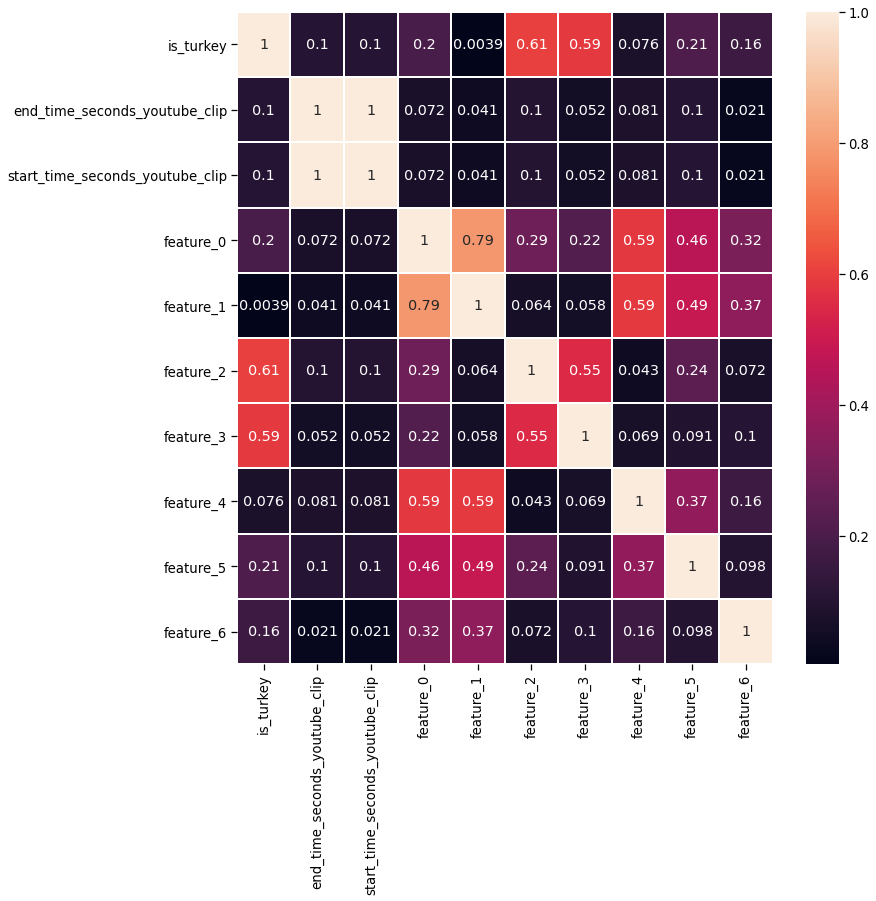

In [16]:
corr = abs(df_train.corr()[:10])
corr_2 = corr[corr.columns[:10].to_list()]
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2})
plt.figure(figsize = (12,12))
sns.heatmap(corr_2,linecolor ='white',linewidths=1,annot=True)

**Feature engineering**

In [17]:
df_train['duration'] = df_train['end_time_seconds_youtube_clip'] - df_train['start_time_seconds_youtube_clip']
df_test['duration'] = df_test['end_time_seconds_youtube_clip'] - df_test['start_time_seconds_youtube_clip']

train_columns = df_train.columns
test_columns = df_test.columns

df_train['all_feature_mean'] = df_train[train_columns[4:131]].mean(axis=1)
df_test['all_feature_mean'] = df_test[test_columns[3:130]].mean(axis=1)

df_train['all_feature_median'] = df_train[train_columns[4:131]].median(axis=1)
df_test['all_feature_median'] = df_test[test_columns[3:130]].median(axis=1)

df_train['all_feature_max'] = df_train[train_columns[4:131]].max(axis=1)
df_test['all_feature_max'] = df_test[test_columns[3:130]].max(axis=1)

df_train['all_feature_min'] = df_train[train_columns[4:131]].min(axis=1)
df_test['all_feature_min'] = df_test[test_columns[3:130]].min(axis=1)

df_train['all_feature_std'] = df_train[train_columns[4:131]].std(axis=1)
df_test['all_feature_std'] = df_test[test_columns[3:130]].std(axis=1)

df_train.drop('end_time_seconds_youtube_clip', axis=1, inplace=True)
df_test.drop('end_time_seconds_youtube_clip', axis=1, inplace=True)

df_train_concat = df_train.groupby('vid_id').mean()
df_test_concat = df_test.groupby('vid_id').mean()

In [18]:
X = df_train_concat.drop('is_turkey', axis=1)   # features
y = df_train_concat['is_turkey']                # target

In [19]:
def cross_val(train_set, target, test_set, nfold, cv_type, seed, shuffle, model):
    """
    Function performs cross-validation
    returns train predictions and test predictions    
    
    """
    if cv_type == 'KFold':
        kf = KFold(n_splits = nfold, shuffle = shuffle, random_state = seed)
        split = kf.split(train_set)
    else:
        kf = StratifiedKFold(n_splits = nfold, shuffle = shuffle, random_state = seed)
        split = kf.split(train_set, target)
        
    oof_preds = np.zeros(train_set.shape[0])
    oof_test = np.zeros(test_set.shape[0])
    
    for i, (train_index, val_index) in enumerate(split):
        x_tr, y_tr = train_set.iloc[train_index], target[train_index]
        x_val, y_val = train_set.iloc[val_index], target[val_index]
        params = {'random_state':seed}
        model.set_params(**params)
        model.fit(x_tr, y_tr)
        oof_preds[val_index] = model.predict_proba(x_val)[:,1]
        oof_test = oof_test + model.predict_proba(test_set)[:, 1] / kf.n_splits
        print('Fold %s ROC:' %str(i+1), np.round(roc_auc_score(y_val, oof_preds[val_index]),5))
        
    print("CV Score:", np.round(roc_auc_score(target, oof_preds),5))
    return oof_preds.reshape(-1,1), oof_test.reshape(-1,1)

In [20]:
def plot_roc_auc_graph(y_true, y_pred, model):
    """
    Function plots ROC AUC graph
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    sns.set('talk', 'whitegrid', 'dark', font_scale=1.2,rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
    plt.figure()
    plt.plot(fpr, tpr, color='red', lw=2.5, label='ROC Curve (AUC: %.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2.5, linestyle='--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str(model) + ' ROC')
    plt.legend(loc="lower right")
    plt.show()
    return None

**1. Random Forest Classifier**

In [21]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200, min_samples_split=3)
oof_train_rf, oof_test_rf = cross_val(train_set=X, target=y, test_set=df_test_concat, cv_type='SKFold', nfold=5, shuffle=True, model=rfc, seed=0)

Fold 1 ROC: 0.99001
Fold 2 ROC: 0.99099
Fold 3 ROC: 0.98545
Fold 4 ROC: 0.97738
Fold 5 ROC: 0.9904
CV Score: 0.9867


**2. XGBoost Classifier**

In [22]:
from xgboost import XGBClassifier

XGB = XGBClassifier(max_depth=3, learning_rate=0.07, n_estimators=100, n_jobs=-1)
oof_train_xgb, oof_test_xgb = cross_val(train_set=X, target=y, test_set=df_test_concat, cv_type="SKFold", nfold=5, seed=0, shuffle=True, model=XGB)

Fold 1 ROC: 0.99001
Fold 2 ROC: 0.98951
Fold 3 ROC: 0.98401
Fold 4 ROC: 0.98307
Fold 5 ROC: 0.98932
CV Score: 0.98725


**3. LightGBM Classifier**

In [23]:
from lightgbm import LGBMClassifier

LGBC = LGBMClassifier(max_depth=-1, n_estimators=100, num_leaves=31)
oof_train_lgb, oof_test_lgb = cross_val(train_set=X, target=y, test_set=df_test_concat, cv_type="SKFold", nfold=5, seed=0, shuffle=True, model=LGBC)

Fold 1 ROC: 0.98936
Fold 2 ROC: 0.99168
Fold 3 ROC: 0.98625
Fold 4 ROC: 0.98343
Fold 5 ROC: 0.99091
CV Score: 0.98832


**4. Logistic Regression**

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.00001,penalty='l2', solver="sag", max_iter=100)
oof_train_lr, oof_test_lr = cross_val(train_set=X, target=y, test_set=df_test_concat, cv_type="SKFold", nfold=5, seed=0, shuffle=True, model=lr)

Fold 1 ROC: 0.99095
Fold 2 ROC: 0.99168
Fold 3 ROC: 0.98567
Fold 4 ROC: 0.98639
Fold 5 ROC: 0.98579
CV Score: 0.98821


**Plot ROC AUC graphs for all four classifiers**[](http://)

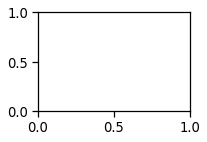

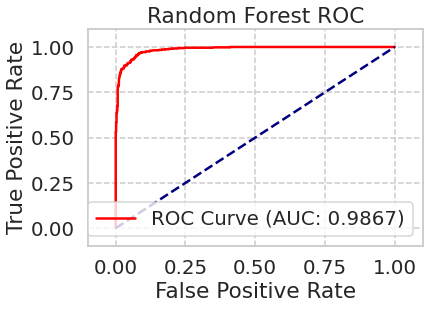

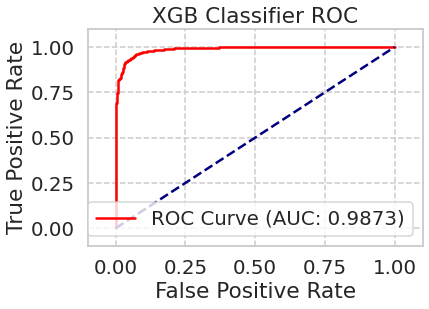

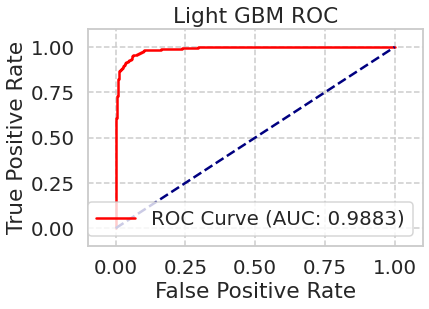

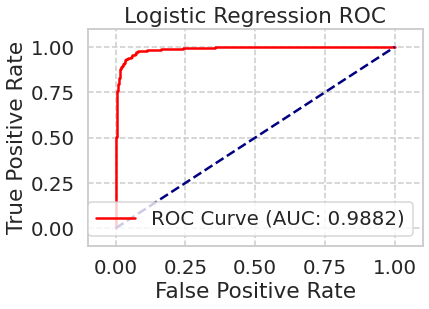

In [25]:
preds = [oof_train_rf, oof_train_xgb, oof_train_lgb, oof_train_lr]
models = ['Random Forest', 'XGB Classifier', 'Light GBM', 'Logistic Regression']
fig = plt.figure()
for i in range(1,5):
    ax = fig.add_subplot(2,2,i)
    ax = plot_roc_auc_graph(y, preds[i-1], models[i-1])
plt.show()

LightGBM and Logistic Regression have performed relatively better than Random Forest Classifier & XGBoost Classifier. I will go ahead with Logistic Regression. 

**Generate final submission**

In [26]:
y_pred_proba = oof_test_lr
y_pred_proba = pd.DataFrame(y_pred_proba, columns=['is_turkey'])
df_test_concat.reset_index(inplace = True)
df_test_concat['is_turkey'] = y_pred_proba['is_turkey']
df_sub = df_test_concat[['vid_id', 'is_turkey']]

df_final = pd.merge(sample, df_sub, on='vid_id')
df_final.drop('is_turkey_x', axis=1, inplace=True)
df_final.columns = ['vid_id', 'is_turkey']
df_final.to_csv('submission.csv', index=False)